In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.optimize import linear_sum_assignment
import torch

import sys
sys.path.append('..')
from src.interface import UnitedNet
from src.configs import *
import copy as copy


In [2]:
def partitions(celltype, n_partitions, seed=0):
    """
    adapted from https://github.com/AllenInstitute/coupledAE-patchseq
    """
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

    # Safe to ignore warning - there are celltypes with a low sample number that are not crucial for the analysis.
    with warnings.catch_warnings():
        skf = StratifiedKFold(n_splits=n_partitions, random_state=seed, shuffle=True)

    # Get all partition indices from the sklearn generator:
    ind_dict = [{'train': train_ind, 'val': val_ind} for train_ind, val_ind in
                skf.split(X=np.zeros(shape=celltype.shape), y=celltype)]
    return ind_dict
    

In [3]:
def pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False):
  adata_rna,adata_ephys,adata_morph = adata_rna_raw.copy(),adata_ephys_raw.copy(),adata_morph_raw.copy()
  adatas_train,adatas_test = [],[]
  assert (adata_rna.X>=0).all(), "poluted input"
  for mod in [adata_rna,adata_ephys,adata_morph]:
    mod.obs['label'] = mod.obs['cell_type_TEM']
    if split:
      m_train = mod[ind_dict[cv]['train']]
      scaler = preprocessing.StandardScaler().fit(m_train.X)
      m_train.X = scaler.transform(m_train.X)

      m_test = mod[ind_dict[cv]['val']]
      scaler = preprocessing.StandardScaler().fit(m_test.X)
      m_test.X = scaler.transform(m_test.X)
    else:
      scaler = preprocessing.StandardScaler().fit(mod.X)
      mod.X = scaler.transform(mod.X)
      m_train = mod[ind_dict[cv]['train']]
      m_test = mod[ind_dict[cv]['val']]

    adatas_train.append(m_train)
    adatas_test.append(m_test)
  adatas_all = [ad.concat([m_train,m_test]) for m_train,m_test in zip(adatas_train,adatas_test)]
  return adatas_train,adatas_test,adatas_all

# load input patch-seq data

In [4]:
technique = 'patchseq'
data_path = f"../data/{technique}"
device = "cuda:0"
root_save_path = f"../saved_results/{technique}"
#load data
adata_rna_raw = sc.read_h5ad(f'{data_path}/adata_RNA_TEM.h5ad')
adata_ephys_raw = sc.read_h5ad(f'{data_path}/adata_Ephys_TEM.h5ad')
adata_morph_raw = sc.read_h5ad(f'{data_path}/adata_Morph_TEM.h5ad')
ind_dict = partitions(adata_rna_raw.obs['cell_type_TEM'], n_partitions=10, seed=0)


In [5]:
for cv in range(10):
  adatas_train,adatas_test,_ = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=True)
  root_save_path = f"./saved_results/{technique}_{cv}"
  model = UnitedNet(root_save_path, device=device, technique=patchseq_config)
  model.train(adatas_train,adatas_val = adatas_test)

  print(model.evaluate(adatas_test))
  _,_,adatas_all = pre_ps(adata_rna_raw,adata_ephys_raw,adata_morph_raw,cv,split=False)
  model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
  model.model.device_in_use = device
  model.model.config['train_task'] = "unsupervised_group_identification"
  model.model.config['train_epochs'] = 20
  model.train(adatas_all,verbose=True,init_classify=True)
  
  

training


100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


{'r2': array([[0.22034235, 0.17000458, 0.12071523],
       [0.31341888, 0.59487978, 0.15842088],
       [0.13421164, 0.08866945, 0.45442737]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.486847
ddc_loss_head_5            0.152768
ddc_loss_head_0            0.153072
self_entropy_loss_head_7  -0.0316483
ddc_loss_head_2            0.15408
ddc_loss_head_6            0.154137
ddc_loss_head_8            0.155096
self_entropy_loss_head_3  -0.0315935
ddc_loss_head_1            0.153534
self_entropy_loss_head_5  -0.0314372
ddc_loss_head_4            0.152758
ddc_loss_head_9            0.155382
self_entropy_loss_head_8  -0.0314574
ddc_loss_head_7            0.152613
self_entropy_loss_head_0  -0.031547
self_entropy_loss_head_9  -0.0313669
self_entropy_loss_head_6  -0.0317352
ddc_loss_head_3            0.15443
self_entropy_loss_head_1  -0.0313482
self_entropy_loss_head_4  -0.0311212
self_entropy_loss_head_2  -0.0312718
best_head                  9
best model saved at ./saved_results/patchseq_0/train_best.pt 

model saved at ./saved_results/patchseq_0/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:29,  4.73s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27419297 0.25087628 0.23486262]
            [0.35330198 0.68757116 0.36987921]
            [0.26527119 0.29970057 0.54879687]]
confusion  [[25  0  0  1  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:09<01:22,  4.56s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26410505 0.24860959 0.23545775]
            [0.35159392 0.70004767 0.37437116]
            [0.24311591 0.31635045 0.55157282]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:13<01:14,  4.38s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26670903 0.25040468 0.24497995]
            [0.33025047 0.69308087 0.38808767]
            [0.26328746 0.30885524 0.56521549]]
confusion  [[27  0  0  0  0  0  8  0  0  0  3  0  0  0  0  0  3  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 12 14  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2 28  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:17<01:08,  4.31s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27108886 0.2537199  0.24403765]
            [0.35699058 0.70526425 0.38739871]
            [0.26530184 0.31972376 0.57429639]]
confusion  [[22  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
              0  0  0]
            [ 0  0  2 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 32  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  5
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:21<01:03,  4.25s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2703335  0.2710017  0.24138887]
            [0.35030682 0.73259029 0.42405177]
            [0.26564603 0.33286204 0.58908861]]
confusion  [[23  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 36  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  3  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:25<00:58,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2834556  0.26753544 0.25992595]
            [0.36795616 0.73828656 0.42192387]
            [0.27263117 0.31079798 0.6115009 ]]
confusion  [[35  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:29<00:54,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27628944 0.27557691 0.26717889]
            [0.38085534 0.75319929 0.44088694]
            [0.27891089 0.36253806 0.62480548]]
confusion  [[27  8  0  0  0  0  0  0  4  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:34<00:49,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28558683 0.27949534 0.27683944]
            [0.383202   0.78287258 0.47561615]
            [0.27917413 0.36772462 0.63572666]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              7  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:38<00:45,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27803619 0.28857597 0.28615694]
            [0.38986605 0.76816355 0.49170473]
            [0.27253093 0.38466119 0.64899412]]
confusion  [[35  2  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              8  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:42<00:41,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28652646 0.29220027 0.29021174]
            [0.39215842 0.78902726 0.50089356]
            [0.28414249 0.38803673 0.6386766 ]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 24  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:47<00:39,  4.34s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27900947 0.29352011 0.29201876]
            [0.3672962  0.8024749  0.52196493]
            [0.29067752 0.41302363 0.65273909]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:51<00:34,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29332238 0.3045522  0.30454254]
            [0.40883007 0.81316551 0.52318114]
            [0.31038275 0.42860721 0.67577506]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:55<00:29,  4.26s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29481989 0.30053466 0.30256353]
            [0.40634142 0.81145524 0.54369401]
            [0.30831075 0.44419369 0.69051664]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:59<00:25,  4.24s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29288231 0.30389622 0.30952707]
            [0.40700191 0.82208064 0.54984862]
            [0.3231286  0.4529268  0.68537077]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:03<00:21,  4.25s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30119784 0.30948338 0.31794091]
            [0.41561861 0.8358817  0.56994638]
            [0.32306249 0.46796854 0.70174874]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:08<00:16,  4.24s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30188697 0.32303471 0.32499819]
            [0.41229642 0.84383317 0.59265677]
            [0.32884858 0.46141586 0.71809124]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:12<00:12,  4.26s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30474579 0.32906843 0.32965119]
            [0.41587647 0.83718361 0.60875791]
            [0.31985183 0.50002486 0.71908205]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:16<00:08,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29858688 0.33673673 0.33692729]
            [0.42325606 0.83309825 0.59578526]
            [0.32861893 0.51718426 0.71307576]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:21<00:04,  4.33s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30297097 0.33394658 0.34545057]
            [0.42595219 0.85435251 0.63410892]
            [0.32276306 0.52972978 0.73785046]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:25<00:00,  4.28s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3116888  0.34792879 0.35222463]
            [0.43372919 0.87128188 0.64617642]
            [0.33218426 0.53519554 0.74324267]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


{'r2': array([[0.19375507, 0.15107075, 0.06866588],
       [0.2771875 , 0.57221342, 0.14501641],
       [0.07905717, 0.07356087, 0.43618957]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.532153
ddc_loss_head_5            0.151039
ddc_loss_head_0            0.149458
self_entropy_loss_head_7  -0.0317731
ddc_loss_head_2            0.149795
ddc_loss_head_6            0.149285
ddc_loss_head_8            0.149443
self_entropy_loss_head_3  -0.0315357
ddc_loss_head_1            0.150846
self_entropy_loss_head_5  -0.0314864
ddc_loss_head_4            0.150154
ddc_loss_head_9            0.150779
self_entropy_loss_head_8  -0.0309817
ddc_loss_head_7            0.153977
self_entropy_loss_head_0  -0.0312486
self_entropy_loss_head_9  -0.0316105
self_entropy_loss_head_6  -0.0315748
ddc_loss_head_3            0.148909
self_entropy_loss_head_1  -0.0313974
self_entropy_loss_head_4  -0.0315234
self_entropy_loss_head_2  -0.0314671
best_head                  6
best model saved at ./saved_results/patchseq_1/train_best.pt 

model saved at ./saved_results/patchseq_1/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:21,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26102848 0.23756405 0.20583231]
            [0.34859274 0.64365667 0.32986706]
            [0.22102025 0.24200837 0.46996177]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  5  0  6  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7
              0  0  0]
            [ 0  0  0  0  0  1  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  9  0  0 28  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:16,  4.23s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26149207 0.23700537 0.20838163]
            [0.34109407 0.63641354 0.33992413]
            [0.22941913 0.24557143 0.50017977]]
confusion  [[36  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15  1  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11
              0  0  0]
            [ 0  0  0  0  7  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 17 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:11,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26412052 0.23930495 0.21836334]
            [0.34920415 0.63512106 0.34912412]
            [0.2282274  0.24774051 0.51787323]]
confusion  [[37  2  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 26  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:07,  4.19s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26229129 0.24494651 0.21785322]
            [0.35173    0.65712998 0.35406721]
            [0.23865974 0.27906732 0.52590008]]
confusion  [[35  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 28  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:21<01:02,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26299697 0.24630822 0.22140355]
            [0.36691799 0.67501322 0.38338069]
            [0.24020717 0.26534424 0.54045488]]
confusion  [[26  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  6  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:26<01:04,  4.61s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27264754 0.24986062 0.24172767]
            [0.36528971 0.66988395 0.38552303]
            [0.25283322 0.28824102 0.55275596]]
confusion  [[19 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 11 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:33<01:12,  5.57s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2703277  0.25856487 0.24724791]
            [0.36957265 0.71973931 0.3989181 ]
            [0.26132944 0.29434471 0.57769398]]
confusion  [[29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             12  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:38<01:02,  5.17s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2821388  0.27399435 0.25506827]
            [0.36764645 0.70876018 0.40639612]
            [0.27914132 0.32639368 0.57426292]]
confusion  [[35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0 13 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:42<00:53,  4.91s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28546343 0.2672598  0.25803512]
            [0.37527712 0.74639336 0.43169046]
            [0.29113087 0.32117675 0.57457092]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  3 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:47<00:47,  4.76s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28551102 0.28367785 0.25927143]
            [0.38735108 0.73023187 0.45250965]
            [0.28191658 0.35947626 0.59556229]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:51<00:41,  4.63s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28807827 0.27550515 0.26220199]
            [0.40522309 0.74932907 0.45506998]
            [0.28530096 0.35750214 0.60948776]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:55<00:36,  4.55s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29490427 0.28831169 0.2798789 ]
            [0.40318945 0.77168566 0.46646741]
            [0.27327286 0.36398699 0.62916092]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:59<00:31,  4.43s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2898318  0.28595612 0.28972507]
            [0.3893761  0.77510658 0.49889093]
            [0.28484666 0.38355562 0.62358354]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [01:04<00:25,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28746911 0.29380867 0.29178556]
            [0.41368706 0.78371111 0.50107856]
            [0.30134836 0.41744433 0.64831174]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:08<00:21,  4.26s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29154289 0.29698017 0.29773919]
            [0.41532333 0.7970551  0.51595896]
            [0.27537881 0.41208674 0.65595181]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:12<00:16,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30481852 0.31024866 0.30781318]
            [0.42308204 0.80782765 0.52884043]
            [0.2933203  0.44845361 0.6725366 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:16<00:12,  4.18s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30267353 0.31382468 0.3066296 ]
            [0.42994355 0.81892806 0.55742695]
            [0.3080068  0.44652978 0.69112335]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:20<00:08,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30058079 0.31756376 0.31547597]
            [0.42428291 0.82460173 0.55859977]
            [0.32172165 0.45552027 0.70342568]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:24<00:04,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3084625  0.31026661 0.3205224 ]
            [0.43510905 0.82113591 0.58030701]
            [0.30768019 0.44128005 0.68592902]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:28<00:00,  4.44s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30382429 0.32439989 0.3255184 ]
            [0.43484923 0.84221276 0.58419204]
            [0.32318462 0.49895786 0.71420024]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:56<00:00,  2.85s/it]


{'r2': array([[0.22012876, 0.16867763, 0.12222473],
       [0.32215234, 0.6573626 , 0.17733593],
       [0.16746854, 0.14728283, 0.4963428 ]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.530245
ddc_loss_head_5            0.147423
ddc_loss_head_0            0.150854
self_entropy_loss_head_7  -0.031221
ddc_loss_head_2            0.149282
ddc_loss_head_6            0.148088
ddc_loss_head_8            0.150221
self_entropy_loss_head_3  -0.031504
ddc_loss_head_1            0.150948
self_entropy_loss_head_5  -0.0316232
ddc_loss_head_4            0.148574
ddc_loss_head_9            0.150322
self_entropy_loss_head_8  -0.031444
ddc_loss_head_7            0.149721
self_entropy_loss_head_0  -0.0312446
self_entropy_loss_head_9  -0.0311953
self_entropy_loss_head_6  -0.031192
ddc_loss_head_3            0.148362
self_entropy_loss_head_1  -0.0315646
self_entropy_loss_head_4  -0.0316429
self_entropy_loss_head_2  -0.0313734
best_head                  2
best model saved at ./saved_results/patchseq_2/train_best.pt 

model saved at ./saved_results/patchseq_2/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:18,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25785254 0.23137513 0.21067176]
            [0.33160357 0.62913379 0.32175204]
            [0.21845447 0.24507456 0.493379  ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  0  1  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 26  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  0  2  1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  6  0 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:14,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26749743 0.24865312 0.2147422 ]
            [0.33763938 0.64875141 0.33280623]
            [0.2426285  0.26915209 0.51055059]]
confusion  [[26  0  0  0  2  0 11  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:10,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25540094 0.24364761 0.22447229]
            [0.33409674 0.65677597 0.34968678]
            [0.24275756 0.28114958 0.54994932]]
confusion  [[15  0  0  0  2  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13
              2  0  0]
            [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  0  0  0  0  0  0  0  0  0  4  0  0  0  0  3  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:06,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27203779 0.24947177 0.23534115]
            [0.35082819 0.65629594 0.35812884]
            [0.25523993 0.28156378 0.55692015]]
confusion  [[29  0  4  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:20<01:02,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26536345 0.25618152 0.2368366 ]
            [0.35326564 0.67880536 0.35362866]
            [0.26200706 0.29959684 0.54292375]]
confusion  [[27 10  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:24<00:58,  4.15s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27373236 0.2685992  0.22748062]
            [0.35137685 0.71154452 0.37461299]
            [0.2640442  0.3079723  0.57268571]]
confusion  [[22 10  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:29<00:54,  4.18s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28158153 0.27840335 0.25705947]
            [0.3676674  0.72182939 0.39701422]
            [0.25381588 0.32209607 0.60289698]]
confusion  [[35  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  1]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 27  0  0  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:33<00:50,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27537077 0.2777936  0.26066207]
            [0.37339249 0.72740608 0.4188229 ]
            [0.27573541 0.34155221 0.60494018]]
confusion  [[29  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  1]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:37<00:46,  4.23s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27769182 0.27481116 0.26898816]
            [0.36905218 0.74299367 0.42310633]
            [0.2734472  0.36045906 0.63154341]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:41<00:41,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28810246 0.28866806 0.27720931]
            [0.36538408 0.76394449 0.4457269 ]
            [0.24419501 0.36117858 0.64610493]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:46<00:37,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29011551 0.29515213 0.28495509]
            [0.38039436 0.76444316 0.45865925]
            [0.2766123  0.38039423 0.6590012 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:50<00:34,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28701095 0.2912536  0.28024536]
            [0.37816258 0.75954776 0.45095055]
            [0.26377182 0.39341643 0.66234034]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:54<00:29,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28252334 0.29882312 0.29184787]
            [0.38440569 0.78945752 0.48781321]
            [0.29197818 0.40025535 0.66523109]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:58<00:25,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28160229 0.3065679  0.29263096]
            [0.39793751 0.79634504 0.49826892]
            [0.29567641 0.43567103 0.67537596]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:02<00:20,  4.18s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28771581 0.31457963 0.30439197]
            [0.40832629 0.82023202 0.51524738]
            [0.29217167 0.44916176 0.70278659]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:06<00:16,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29138817 0.32485799 0.31249247]
            [0.40983005 0.8224048  0.53636482]
            [0.31168158 0.46130482 0.71346889]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:11<00:12,  4.13s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29667601 0.33159011 0.31501674]
            [0.41195197 0.833401   0.56030015]
            [0.31957779 0.43538732 0.6964878 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:15<00:08,  4.13s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29986561 0.34244359 0.31422249]
            [0.41966601 0.8443116  0.55235548]
            [0.31899064 0.47601124 0.71725301]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:19<00:04,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29881972 0.3443284  0.32914784]
            [0.43550453 0.84861917 0.59597727]
            [0.31832586 0.49833192 0.73372508]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:23<00:00,  4.16s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30770531 0.35149944 0.33702237]
            [0.43618916 0.8583257  0.60470848]
            [0.29556506 0.51457869 0.74146335]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


{'r2': array([[0.21579758, 0.16017713, 0.11421572],
       [0.31819182, 0.63953923, 0.19181556],
       [0.18654274, 0.10097319, 0.51656868]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.530465
ddc_loss_head_5            0.152732
ddc_loss_head_0            0.150009
self_entropy_loss_head_7  -0.0314587
ddc_loss_head_2            0.15025
ddc_loss_head_6            0.154019
ddc_loss_head_8            0.149399
self_entropy_loss_head_3  -0.0314899
ddc_loss_head_1            0.151361
self_entropy_loss_head_5  -0.031785
ddc_loss_head_4            0.152473
ddc_loss_head_9            0.150422
self_entropy_loss_head_8  -0.0315408
ddc_loss_head_7            0.151114
self_entropy_loss_head_0  -0.0315708
self_entropy_loss_head_9  -0.0316551
self_entropy_loss_head_6  -0.0314664
ddc_loss_head_3            0.15157
self_entropy_loss_head_1  -0.0315309
self_entropy_loss_head_4  -0.0313864
self_entropy_loss_head_2  -0.0316203
best_head                  8
best model saved at ./saved_results/patchseq_3/train_best.pt 

model saved at ./saved_results/patchseq_3/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:23,  4.40s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25461244 0.2342728  0.21511554]
            [0.3381759  0.64794946 0.3246841 ]
            [0.22609157 0.2449188  0.47709969]]
confusion  [[36  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 27  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  4  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  4  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  3  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:18,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25652331 0.23738974 0.21871157]
            [0.32510369 0.66812379 0.35190937]
            [0.22281981 0.24524005 0.5333815 ]]
confusion  [[38  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 13  7  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  0  7  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:13<01:14,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.25563794 0.23352015 0.23004251]
            [0.32441625 0.67325825 0.35859032]
            [0.21940423 0.25525597 0.54361185]]
confusion  [[26  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 31  4  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:17<01:09,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26079032 0.2370134  0.2269525 ]
            [0.34419187 0.6561876  0.35413664]
            [0.22818157 0.26802476 0.55975766]]
confusion  [[25 15  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 13  0  2 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:21<01:04,  4.33s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2653155  0.25134447 0.23722056]
            [0.34514757 0.7058225  0.38948012]
            [0.25751081 0.27773051 0.56441676]]
confusion  [[38  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0 21  0  0 12  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:26<01:00,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27351024 0.25632581 0.24367219]
            [0.36729296 0.70882286 0.38308663]
            [0.25445229 0.28474772 0.57918322]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 33  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:30<00:56,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27588199 0.25565085 0.24397143]
            [0.36300627 0.74045067 0.41516219]
            [0.258625   0.31767754 0.58321304]]
confusion  [[40  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:34<00:52,  4.34s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27722912 0.27244604 0.25077747]
            [0.35686821 0.74551492 0.42179235]
            [0.27835042 0.34563643 0.59445435]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:39<00:48,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28273825 0.279307   0.26301916]
            [0.37363567 0.75778481 0.4498568 ]
            [0.25203091 0.276122   0.60670327]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:43<00:43,  4.34s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28232031 0.28417345 0.26680236]
            [0.3709296  0.76697964 0.44321801]
            [0.27351715 0.32890276 0.63675319]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:47<00:38,  4.26s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2887151  0.28825143 0.27766621]
            [0.39095772 0.78920889 0.44925146]
            [0.28261272 0.38112702 0.6494128 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:51<00:33,  4.23s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28885273 0.29348035 0.27234192]
            [0.38347247 0.79931693 0.48657509]
            [0.28934926 0.38400422 0.65806065]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:55<00:29,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29299873 0.30654212 0.28151412]
            [0.388405   0.79441832 0.49306109]
            [0.28636058 0.40514292 0.66389335]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [01:00<00:25,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29493501 0.30323896 0.29061793]
            [0.3952896  0.81885893 0.49925582]
            [0.28643123 0.4148264  0.67532899]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  3  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:04<00:21,  4.33s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29499531 0.31162149 0.3003986 ]
            [0.39930798 0.8172305  0.53112115]
            [0.30317924 0.4217819  0.68770667]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:09<00:17,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29065534 0.32117609 0.30053523]
            [0.39871433 0.82707628 0.53152063]
            [0.30897055 0.44017779 0.68633341]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:13<00:13,  4.39s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30045737 0.32062351 0.31106336]
            [0.406928   0.81976681 0.5565867 ]
            [0.31433432 0.44999067 0.70111349]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:18<00:08,  4.40s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30039492 0.32619314 0.30451015]
            [0.41547853 0.83029944 0.55188378]
            [0.31748421 0.45813124 0.706216  ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:22<00:04,  4.36s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30537922 0.33144076 0.31531731]
            [0.41186013 0.81731789 0.58493698]
            [0.32146144 0.46686085 0.70865537]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:26<00:00,  4.33s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30665582 0.3408344  0.32239048]
            [0.41911826 0.8338728  0.60628379]
            [0.33342987 0.5039599  0.71996252]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]


{'r2': array([[0.21024696, 0.14834876, 0.09654654],
       [0.30881786, 0.60200702, 0.05549136],
       [0.11876682, 0.0516265 , 0.47452459]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.525586
ddc_loss_head_5            0.151283
ddc_loss_head_0            0.152708
self_entropy_loss_head_7  -0.0315185
ddc_loss_head_2            0.147647
ddc_loss_head_6            0.15039
ddc_loss_head_8            0.150913
self_entropy_loss_head_3  -0.0317346
ddc_loss_head_1            0.151996
self_entropy_loss_head_5  -0.0314618
ddc_loss_head_4            0.151726
ddc_loss_head_9            0.1481
self_entropy_loss_head_8  -0.0314804
ddc_loss_head_7            0.152861
self_entropy_loss_head_0  -0.0315698
self_entropy_loss_head_9  -0.0316249
self_entropy_loss_head_6  -0.0315457
ddc_loss_head_3            0.152049
self_entropy_loss_head_1  -0.0315341
self_entropy_loss_head_4  -0.0314823
self_entropy_loss_head_2  -0.0309679
best_head                  6
best model saved at ./saved_results/patchseq_4/train_best.pt 

model saved at ./saved_results/patchseq_4/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:03<01:15,  3.98s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26483521 0.23017025 0.21720324]
            [0.33770685 0.62799495 0.34584618]
            [0.24830661 0.26769938 0.50140908]]
confusion  [[31  4  0  0  5  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 18  0  0  8  0  0  0  1  0  0  0  1  2  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  7  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  8  0 21  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  4
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:13,  4.09s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26715641 0.23690279 0.22458518]
            [0.34061492 0.65047396 0.35509774]
            [0.26127302 0.28383348 0.53662656]]
confusion  [[19 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7
              0  0  0]
            [ 0  0  2  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 10  0 19  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:09,  4.07s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26005866 0.23852857 0.22473734]
            [0.3380287  0.63613007 0.35365285]
            [0.23929334 0.26154388 0.52127781]]
confusion  [[13  0  0  0  0  0  0  0 11  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0 27  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  2 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:05,  4.09s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26837686 0.25230519 0.2293984 ]
            [0.34232686 0.67913925 0.36839025]
            [0.25396166 0.30391946 0.55461783]]
confusion  [[18  0  0  0  0  0 11  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:20<01:03,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26831312 0.25360569 0.23377874]
            [0.35410812 0.69195231 0.37687906]
            [0.24665725 0.2992681  0.57550554]]
confusion  [[31  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  6  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  8  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:24<00:58,  4.18s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26204073 0.25882635 0.23996527]
            [0.35186128 0.68670839 0.36782518]
            [0.25303553 0.31272012 0.58452101]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:28<00:54,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27645105 0.26132345 0.25308161]
            [0.36668666 0.71360768 0.41564195]
            [0.25522111 0.33182639 0.57434844]]
confusion  [[27 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:32<00:49,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27460813 0.27209422 0.25442722]
            [0.37036774 0.72996834 0.40525832]
            [0.24913114 0.3370168  0.60712572]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:36<00:44,  4.07s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28122039 0.27349089 0.2601265 ]
            [0.37583225 0.7337475  0.43005313]
            [0.28798871 0.35835598 0.62559681]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:40<00:40,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2821641  0.27339851 0.25666938]
            [0.39317248 0.74359716 0.43103296]
            [0.28070313 0.36776602 0.62078282]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:44<00:36,  4.01s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28702646 0.28798866 0.27019721]
            [0.3987199  0.77516588 0.44022965]
            [0.29661391 0.36426242 0.6352095 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:48<00:31,  3.97s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28553259 0.29247761 0.27750231]
            [0.37018074 0.77793333 0.46004307]
            [0.29336232 0.40157168 0.62432586]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:52<00:27,  3.95s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28864066 0.28492381 0.27555068]
            [0.39295408 0.79599367 0.46450336]
            [0.28179254 0.4062725  0.66199608]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:56<00:23,  3.93s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29164068 0.29950072 0.29026865]
            [0.4009839  0.7910585  0.4717851 ]
            [0.30644371 0.41995222 0.66500315]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:00<00:20,  4.02s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29242941 0.3027948  0.2934223 ]
            [0.40319764 0.79773874 0.45923719]
            [0.31066833 0.42855592 0.68629459]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:05<00:16,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29257144 0.31023158 0.30174363]
            [0.40902523 0.80489474 0.49578703]
            [0.30410535 0.44493613 0.69132209]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:10<00:13,  4.46s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29680559 0.31518538 0.30453947]
            [0.41822777 0.81375928 0.51937599]
            [0.32245927 0.46917503 0.69655598]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:14<00:08,  4.37s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30426809 0.3224168  0.32007483]
            [0.42233264 0.82131497 0.54139439]
            [0.3279302  0.46349286 0.70513434]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:18<00:04,  4.35s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29962719 0.32391805 0.31547338]
            [0.409454   0.7978418  0.55146883]
            [0.32991687 0.48865736 0.71312809]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:23<00:00,  4.16s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30350674 0.32816806 0.32694324]
            [0.42418817 0.83025937 0.55150232]
            [0.34399576 0.51240091 0.70848156]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:59<00:00,  2.99s/it]


{'r2': array([[0.2281673 , 0.16182583, 0.14461384],
       [0.31015708, 0.59756813, 0.1629047 ],
       [0.14954229, 0.01660895, 0.48748094]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.508116
ddc_loss_head_5            0.152652
ddc_loss_head_0            0.150308
self_entropy_loss_head_7  -0.0316996
ddc_loss_head_2            0.15362
ddc_loss_head_6            0.149058
ddc_loss_head_8            0.150854
self_entropy_loss_head_3  -0.0312251
ddc_loss_head_1            0.150715
self_entropy_loss_head_5  -0.0315369
ddc_loss_head_4            0.152392
ddc_loss_head_9            0.152956
self_entropy_loss_head_8  -0.0314368
ddc_loss_head_7            0.150519
self_entropy_loss_head_0  -0.0315423
self_entropy_loss_head_9  -0.031704
self_entropy_loss_head_6  -0.0316022
ddc_loss_head_3            0.150581
self_entropy_loss_head_1  -0.031603
self_entropy_loss_head_4  -0.0317414
self_entropy_loss_head_2  -0.0316355
best_head                  5
best model saved at ./saved_results/patchseq_5/train_best.pt 

model saved at ./saved_results/patchseq_5/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:21,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26900521 0.251451   0.2204195 ]
            [0.34073315 0.63475168 0.34603397]
            [0.2479404  0.28662744 0.54300664]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  1  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 6  0  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2 25 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:16,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2681666  0.25522361 0.23869304]
            [0.33771371 0.67399731 0.38219568]
            [0.24354164 0.29896972 0.56778178]]
confusion  [[25  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  1  0  0  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  5  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9  0  2 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:12,  4.25s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27098045 0.25091057 0.23917573]
            [0.33714445 0.68719974 0.38779958]
            [0.25172876 0.30161296 0.57880904]]
confusion  [[25  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  2  0
              7  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
              0  0  0]
            [ 0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:17<01:08,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26267335 0.25569756 0.24970172]
            [0.3441263  0.69237182 0.39815591]
            [0.24041016 0.32435156 0.58376526]]
confusion  [[25  1  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  2  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0
              0  0  0]
            [ 0  0  0  1  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:21<01:04,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27695173 0.26151432 0.2508429 ]
            [0.36749181 0.69707978 0.41593759]
            [0.26663233 0.33080341 0.60221843]]
confusion  [[37  0  0  0  0  0  1  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0
              3  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:25<01:01,  4.36s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28055338 0.27254174 0.2564092 ]
            [0.35948618 0.71432765 0.41003422]
            [0.26712259 0.3192505  0.60524157]]
confusion  [[22  0  0  0  0  0  0  0 15  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0
              8  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:30<00:57,  4.39s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28145918 0.2729599  0.25925472]
            [0.3681363  0.735732   0.4296541 ]
            [0.27736281 0.32863297 0.62617607]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 24  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:34<00:52,  4.40s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28597522 0.28416249 0.26703078]
            [0.38757165 0.74179785 0.44876981]
            [0.28130122 0.37013063 0.6390893 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 36  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:39<00:48,  4.41s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28373394 0.28633689 0.27142518]
            [0.38880963 0.75361685 0.4698905 ]
            [0.29093533 0.39122578 0.64535591]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:43<00:44,  4.40s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28929779 0.29634206 0.28640682]
            [0.40376865 0.78502635 0.46854373]
            [0.29035112 0.40482583 0.63899071]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:47<00:39,  4.36s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2955789  0.29597063 0.28761756]
            [0.39510553 0.78869375 0.4753085 ]
            [0.29456097 0.40853638 0.66193213]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:51<00:34,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29439127 0.30252827 0.29379867]
            [0.41704655 0.80769959 0.51969957]
            [0.28815875 0.40933823 0.67992137]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:56<00:29,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29136618 0.30894872 0.29875405]
            [0.40383661 0.81293871 0.52591491]
            [0.28194382 0.38918049 0.69569342]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [01:00<00:25,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2993074  0.31411599 0.30781094]
            [0.42088722 0.80086231 0.54621774]
            [0.30808893 0.44328065 0.70755288]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:04<00:21,  4.23s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29835348 0.31819049 0.31265152]
            [0.42508994 0.82741045 0.55860439]
            [0.30260519 0.41584942 0.70679441]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:08<00:16,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30134928 0.31841051 0.31924275]
            [0.43112939 0.82313653 0.55071681]
            [0.32521803 0.45955859 0.69960888]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:12<00:12,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30021092 0.31751358 0.32003261]
            [0.42375462 0.8338501  0.55410573]
            [0.32019513 0.48495346 0.71877106]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:17<00:08,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29867263 0.32276418 0.32448214]
            [0.44392523 0.82889796 0.57931809]
            [0.29872731 0.48697661 0.72665196]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:21<00:04,  4.19s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30509485 0.3414997  0.33386967]
            [0.43892846 0.84640518 0.60267645]
            [0.32204445 0.51792093 0.73438121]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:25<00:00,  4.27s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30780478 0.34286848 0.34173844]
            [0.43409231 0.8713145  0.60206113]
            [0.33387371 0.53086793 0.75073891]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


{'r2': array([[ 0.22561299,  0.17759471,  0.11568791],
       [ 0.34409941,  0.64293824,  0.1521786 ],
       [ 0.13841837, -0.00495575,  0.47810767]]), 'confusion': array([[2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.496026
ddc_loss_head_5            0.148889
ddc_loss_head_0            0.150435
self_entropy_loss_head_7  -0.0315315
ddc_loss_head_2            0.149921
ddc_loss_head_6            0.149352
ddc_loss_head_8            0.147001
self_entropy_loss_head_3  -0.0316176
ddc_loss_head_1            0.150391
self_entropy_loss_head_5  -0.0316026
ddc_loss_head_4            0.147559
ddc_loss_head_9            0.149528
self_entropy_loss_head_8  -0.0311212
ddc_loss_head_7            0.149744
self_entropy_loss_head_0  -0.0313974
self_entropy_loss_head_9  -0.0314244
self_entropy_loss_head_6  -0.031561
ddc_loss_head_3            0.150868
self_entropy_loss_head_1  -0.0313692
self_entropy_loss_head_4  -0.0312714
self_entropy_loss_head_2  -0.0316666
best_head                  8
best model saved at ./saved_results/patchseq_6/train_best.pt 

model saved at ./saved_results/patchseq_6/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:17,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26306516 0.25045014 0.23116112]
            [0.33258815 0.68839536 0.3527398 ]
            [0.2524254  0.296131   0.53147061]]
confusion  [[27  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
             12  0  0]
            [ 0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0
              0  0  0]
            [ 0  0  0 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0
              0  0  0]
            [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0 13  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:12,  4.06s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27198014 0.25590289 0.24437472]
            [0.35290667 0.70437223 0.38428793]
            [0.25654376 0.32113288 0.55070026]]
confusion  [[36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              5  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  6  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0 29  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:08,  4.04s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26497585 0.25734479 0.23807349]
            [0.35383338 0.68298972 0.40409167]
            [0.25734008 0.31342322 0.56643848]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  4  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  7 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0
              6  0  0]
            [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:04,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27075328 0.2532269  0.25080998]
            [0.3664413  0.71282842 0.4153304 ]
            [0.26688691 0.31939053 0.56733737]]
confusion  [[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  4]
            [ 0  0  0 20  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:20<01:01,  4.09s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28040982 0.26142272 0.25826706]
            [0.35595248 0.72318505 0.4200234 ]
            [0.28159316 0.34124572 0.59202248]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  2  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
             15  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:24<00:57,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26535593 0.2696134  0.25811357]
            [0.36996864 0.74355129 0.42873356]
            [0.27813876 0.34849466 0.59127508]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 34  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:28<00:53,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28033471 0.27136757 0.27221153]
            [0.3759079  0.74146352 0.45042762]
            [0.27333089 0.34807649 0.61344938]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 37  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:32<00:49,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28178291 0.28042734 0.27571695]
            [0.36175389 0.75250014 0.47075925]
            [0.28331084 0.35252814 0.62660577]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0 10  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 36  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:36<00:44,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28950688 0.28946397 0.28120677]
            [0.39248996 0.75545572 0.47278277]
            [0.29996822 0.37691129 0.61948062]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  4  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 25  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:40<00:40,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28935277 0.29510538 0.27635936]
            [0.39322968 0.77580928 0.48194063]
            [0.29751334 0.38509303 0.61071914]]
confusion  [[39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:44<00:36,  4.07s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28675366 0.28950786 0.27632808]
            [0.39778962 0.77095438 0.49890446]
            [0.29344755 0.37467477 0.64881909]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 37  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:48<00:32,  4.06s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29231656 0.30305675 0.27075456]
            [0.40496304 0.79556806 0.48885157]
            [0.30373577 0.40961137 0.66234198]]
confusion  [[40  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 37  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:52<00:28,  4.03s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29386584 0.31398044 0.29828794]
            [0.4114091  0.8127946  0.54566467]
            [0.31237301 0.43500207 0.68008526]]
confusion  [[40  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:56<00:24,  4.02s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2971964  0.30145534 0.29684582]
            [0.41547187 0.81407148 0.5453267 ]
            [0.31424154 0.4444996  0.69417896]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:00<00:20,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29801244 0.32808839 0.30686808]
            [0.42573792 0.82496353 0.5607769 ]
            [0.3239876  0.46977368 0.693286  ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:06<00:17,  4.36s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30094424 0.33129442 0.31764127]
            [0.42194957 0.83240967 0.57861024]
            [0.32378244 0.46601233 0.70500521]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:09<00:12,  4.19s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30585544 0.3431452  0.32082253]
            [0.43859614 0.8347538  0.59436026]
            [0.34037652 0.49677299 0.70692976]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:13<00:08,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30740481 0.33469784 0.32267139]
            [0.4364778  0.84453564 0.57990593]
            [0.3415486  0.47936668 0.71653524]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:17<00:03,  3.98s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30130467 0.34717034 0.33115837]
            [0.45780028 0.85421179 0.61581125]
            [0.34023844 0.51593625 0.71084739]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:21<00:00,  4.06s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3121045  0.36047018 0.33551278]
            [0.46187563 0.86419602 0.63033239]
            [0.35125683 0.53957467 0.74073071]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:55<00:00,  2.80s/it]


{'r2': array([[0.21871287, 0.15393337, 0.10884344],
       [0.25675643, 0.60917397, 0.1268484 ],
       [0.13770446, 0.08117658, 0.50432846]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.493474
ddc_loss_head_5            0.153631
ddc_loss_head_0            0.154326
self_entropy_loss_head_7  -0.031547
ddc_loss_head_2            0.149764
ddc_loss_head_6            0.153196
ddc_loss_head_8            0.154097
self_entropy_loss_head_3  -0.0312273
ddc_loss_head_1            0.15308
self_entropy_loss_head_5  -0.0315567
ddc_loss_head_4            0.152272
ddc_loss_head_9            0.1523
self_entropy_loss_head_8  -0.0314247
ddc_loss_head_7            0.150392
self_entropy_loss_head_0  -0.0316104
self_entropy_loss_head_9  -0.0317929
self_entropy_loss_head_6  -0.0314469
ddc_loss_head_3            0.152314
self_entropy_loss_head_1  -0.0315892
self_entropy_loss_head_4  -0.0314015
self_entropy_loss_head_2  -0.0315414
best_head                  6
best model saved at ./saved_results/patchseq_7/train_best.pt 

model saved at ./saved_results/patchseq_7/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:19,  4.20s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2737462  0.251801   0.2305988 ]
            [0.34986877 0.6753996  0.36868867]
            [0.274966   0.29562098 0.54152708]]
confusion  [[24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  7  0 16  0  2  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  1]
            [ 0  1  5  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:15,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27586199 0.25773181 0.23744009]
            [0.37190574 0.68026711 0.39809474]
            [0.2703439  0.29921658 0.57048323]]
confusion  [[35  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  7  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:11,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27100553 0.25419508 0.24028095]
            [0.33248378 0.67285997 0.38436126]
            [0.24798053 0.29310976 0.57417772]]
confusion  [[27  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 28  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 28  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              9  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:05,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26517534 0.26293035 0.24193747]
            [0.34184228 0.69816827 0.41302261]
            [0.27027999 0.30012392 0.58801632]]
confusion  [[22  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0  1  0
              0  0  0]
            [ 1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 26  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 12  0  1 15  0  0  1  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:20<01:00,  4.00s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26371394 0.26773935 0.23939172]
            [0.35288201 0.71208129 0.41040384]
            [0.25526333 0.31610802 0.59374402]]
confusion  [[29 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0 26  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:24<00:57,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27488316 0.27637593 0.26483102]
            [0.37023586 0.72590693 0.43126192]
            [0.24849511 0.32901305 0.59828124]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 29  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:28<00:54,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28466071 0.27748324 0.26495139]
            [0.37350393 0.7247024  0.43700635]
            [0.26683397 0.34276746 0.61514896]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0
              0  0  0]
            [ 0  0  0 27  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  2  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:32<00:49,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2872279  0.28659008 0.26986897]
            [0.36021829 0.74764036 0.45214424]
            [0.26466914 0.34641733 0.61829793]]
confusion  [[39  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 25  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  4  0  0  0 34  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:37<00:46,  4.21s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28447554 0.28681995 0.28252886]
            [0.35075043 0.78225624 0.47642171]
            [0.25394546 0.36575186 0.63398067]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:41<00:42,  4.23s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29536667 0.29045576 0.28313354]
            [0.38540396 0.75277416 0.48511195]
            [0.28287545 0.36965904 0.64496922]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:46<00:38,  4.26s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29715049 0.29848048 0.28631987]
            [0.39087212 0.78649489 0.48546844]
            [0.27878038 0.39138716 0.6663684 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:50<00:33,  4.22s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29510977 0.30153074 0.29508201]
            [0.39589565 0.80138196 0.5119604 ]
            [0.28450579 0.40993801 0.66910429]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:54<00:29,  4.14s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29796459 0.30986845 0.30069979]
            [0.39903571 0.81337179 0.54298076]
            [0.30633175 0.43095236 0.6889921 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:58<00:24,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30303174 0.31450391 0.31051172]
            [0.41098281 0.82391607 0.55064726]
            [0.28994786 0.42473292 0.70351734]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:01<00:19,  3.97s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30431209 0.31621491 0.3156143 ]
            [0.40947237 0.83506696 0.55964125]
            [0.29920062 0.45425367 0.70496507]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:06<00:16,  4.13s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30424434 0.32346276 0.3240341 ]
            [0.42348561 0.85630305 0.59468054]
            [0.32412522 0.46945201 0.71763295]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  2  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:10<00:12,  4.17s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3041798  0.32708573 0.3258058 ]
            [0.4178964  0.8530793  0.581025  ]
            [0.31791618 0.47686685 0.72494045]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:14<00:08,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3028335  0.32887755 0.3374048 ]
            [0.40500163 0.86393826 0.60430904]
            [0.33282266 0.4951567  0.73820017]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:18<00:04,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31255353 0.34090369 0.33951139]
            [0.42958558 0.86382086 0.62419385]
            [0.31563561 0.50583233 0.73705518]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:22<00:00,  4.14s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.31314607 0.34734814 0.34437556]
            [0.44262683 0.87224543 0.64855168]
            [0.34709526 0.52621279 0.74683304]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:56<00:00,  2.81s/it]


{'r2': array([[0.20410402, 0.14148707, 0.13032613],
       [0.27535308, 0.64026024, 0.17764044],
       [0.18822478, 0.12674025, 0.52765767]]), 'confusion': array([[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.500655
ddc_loss_head_5            0.153026
ddc_loss_head_0            0.151052
self_entropy_loss_head_7  -0.031298
ddc_loss_head_2            0.152161
ddc_loss_head_6            0.152735
ddc_loss_head_8            0.151677
self_entropy_loss_head_3  -0.0312886
ddc_loss_head_1            0.151844
self_entropy_loss_head_5  -0.0312211
ddc_loss_head_4            0.15301
ddc_loss_head_9            0.153449
self_entropy_loss_head_8  -0.0314718
ddc_loss_head_7            0.150792
self_entropy_loss_head_0  -0.0312559
self_entropy_loss_head_9  -0.0314253
self_entropy_loss_head_6  -0.0316759
ddc_loss_head_3            0.154045
self_entropy_loss_head_1  -0.0312104
self_entropy_loss_head_4  -0.0315917
self_entropy_loss_head_2  -0.0311956
best_head                  9
best model saved at ./saved_results/patchseq_8/train_best.pt 

model saved at ./saved_results/patchseq_8/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:18,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26854719 0.24116959 0.22669534]
            [0.34835761 0.67167046 0.35493711]
            [0.25016531 0.25836359 0.5289541 ]]
confusion  [[29  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  3  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  1  0 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:14,  4.16s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27597648 0.24987651 0.24266425]
            [0.3575201  0.66677206 0.38227547]
            [0.26350802 0.30021558 0.55859244]]
confusion  [[23  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 17  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:11,  4.18s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26040915 0.25457861 0.24576641]
            [0.35897586 0.69824394 0.39930931]
            [0.24508816 0.30426704 0.56820615]]
confusion  [[22  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0  4  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  4  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  1  0 28  0  0  0  0  0  7  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:17<01:09,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26621748 0.25397621 0.24114499]
            [0.36460133 0.71299364 0.38174054]
            [0.24747296 0.31200727 0.58559214]]
confusion  [[37  1  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  1  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  6 32  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:21<01:05,  4.35s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27794678 0.25116433 0.25253175]
            [0.36184825 0.68441504 0.38442175]
            [0.26073492 0.30861659 0.59084582]]
confusion  [[31  0  0  0  0  0  8  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0 13 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:25<01:00,  4.34s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26812234 0.25995377 0.25952214]
            [0.36395703 0.72179667 0.41125569]
            [0.27367601 0.33601053 0.60941909]]
confusion  [[37  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  9 19  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:30<00:55,  4.31s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29015634 0.27717999 0.26703857]
            [0.35730287 0.74993194 0.43811227]
            [0.28299894 0.34662521 0.61383369]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  6 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:34<00:51,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28252979 0.24729989 0.26769469]
            [0.36039314 0.71586695 0.44932457]
            [0.28043347 0.3486144  0.6194743 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 27  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              1  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:38<00:47,  4.33s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28108453 0.28400576 0.27098422]
            [0.37670866 0.76557973 0.45400105]
            [0.29404418 0.35275376 0.64663213]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:43<00:43,  4.34s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29113569 0.2875316  0.27597011]
            [0.38999962 0.76285347 0.4630856 ]
            [0.30215566 0.37485831 0.65838994]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:47<00:38,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2897789  0.28269542 0.26953613]
            [0.39657009 0.77643018 0.48532205]
            [0.29727138 0.36889568 0.67248668]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:51<00:34,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29301789 0.29258325 0.29567066]
            [0.40578973 0.79581843 0.5021739 ]
            [0.30784984 0.40011847 0.68170673]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:55<00:29,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29132764 0.3024799  0.30312922]
            [0.39441596 0.79821808 0.52018545]
            [0.29712356 0.42947084 0.6913797 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [01:00<00:25,  4.28s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29461761 0.311967   0.30849538]
            [0.40975657 0.82066362 0.53181899]
            [0.31960584 0.44321789 0.68605336]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:04<00:21,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29442198 0.31415558 0.31111219]
            [0.41137993 0.82508453 0.55629722]
            [0.29446698 0.44712653 0.70386165]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:08<00:17,  4.29s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30223632 0.3250719  0.31074735]
            [0.42618039 0.83965269 0.55147252]
            [0.30784169 0.46234968 0.70199652]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:13<00:12,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29884065 0.32254279 0.31399191]
            [0.41714063 0.83801051 0.56871459]
            [0.32264109 0.47435894 0.7159244 ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:17<00:08,  4.32s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30531221 0.32599961 0.31989886]
            [0.42837037 0.84304801 0.55669221]
            [0.33575311 0.49323124 0.72206612]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:21<00:04,  4.27s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30641176 0.34091779 0.32282579]
            [0.42800327 0.84625281 0.60033906]
            [0.34698083 0.50442612 0.72985378]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:25<00:00,  4.29s/it]




Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30752794 0.33909872 0.33537905]
            [0.38741829 0.85627644 0.59728985]
            [0.33426001 0.51190818 0.74498963]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

100%|██████████| 20/20 [00:55<00:00,  2.77s/it]


{'r2': array([[0.20426601, 0.15999244, 0.11772062],
       [0.18876407, 0.570488  , 0.0942892 ],
       [0.18521174, 0.13159899, 0.53177909]]), 'confusion': array([[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0

  0%|          | 0/20 [00:00<?, ?it/s]



Losses                         Value
------------------------  ----------
reconstruction_loss        0.495098
ddc_loss_head_5            0.151585
ddc_loss_head_0            0.152617
self_entropy_loss_head_7  -0.0310987
ddc_loss_head_2            0.150321
ddc_loss_head_6            0.151272
ddc_loss_head_8            0.153333
self_entropy_loss_head_3  -0.0313339
ddc_loss_head_1            0.147698
self_entropy_loss_head_5  -0.0314702
ddc_loss_head_4            0.152891
ddc_loss_head_9            0.150478
self_entropy_loss_head_8  -0.031374
ddc_loss_head_7            0.15202
self_entropy_loss_head_0  -0.0313094
self_entropy_loss_head_9  -0.031235
self_entropy_loss_head_6  -0.0312941
ddc_loss_head_3            0.15182
self_entropy_loss_head_1  -0.0313391
self_entropy_loss_head_4  -0.0313423
self_entropy_loss_head_2  -0.0312849
best_head                  7
best model saved at ./saved_results/patchseq_9/train_best.pt 

model saved at ./saved_results/patchseq_9/train_epoch_1.pt 



/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
  5%|▌         | 1/20 [00:04<01:17,  4.06s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2750353  0.25443313 0.21903174]
            [0.33754767 0.65293742 0.34740603]
            [0.2452921  0.26975863 0.55789426]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1  0
              0  0  0]
            [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0
              0  0  0]
            [ 0  0  0 24  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
              0  0  0]
            [ 0  0  0  0  4  2  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 10%|█         | 2/20 [00:08<01:12,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27615771 0.2523265  0.24544347]
            [0.35205316 0.69961009 0.39128449]
            [0.24548068 0.30144708 0.60397254]]
confusion  [[18  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  1  0  0  0  0  0
              0  0  1]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 32  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 15%|█▌        | 3/20 [00:12<01:08,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.26397165 0.25674554 0.24638315]
            [0.35324034 0.69208243 0.40671724]
            [0.24139192 0.29270686 0.61127568]]
confusion  [[18  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  0  0  0
              6  0  0]
            [ 0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  5  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 27  9  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 20%|██        | 4/20 [00:16<01:05,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27057288 0.26229957 0.25230281]
            [0.35918027 0.70791696 0.42106809]
            [0.24672846 0.3068515  0.61918892]]
confusion  [[25  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  1  0  3  0  0  0  0  0  0  0  0  0  4  0  0  1  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 30  7  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 25%|██▌       | 5/20 [00:20<01:02,  4.14s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.27086114 0.25826242 0.252409  ]
            [0.3725298  0.72797401 0.41816487]
            [0.25368899 0.31674118 0.64026382]]
confusion  [[28  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              3  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  8  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 30%|███       | 6/20 [00:24<00:57,  4.12s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2836779  0.26873196 0.25762166]
            [0.37479677 0.73456372 0.43051711]
            [0.23884544 0.27881343 0.61864609]]
confusion  [[18  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0
             17  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  4  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 35%|███▌      | 7/20 [00:28<00:53,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28009211 0.27808114 0.26157192]
            [0.34564635 0.73189779 0.44077475]
            [0.2430757  0.35099104 0.63736768]]
confusion  [[39  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 40%|████      | 8/20 [00:32<00:49,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28614612 0.28907555 0.26245546]
            [0.3757003  0.77006104 0.45784437]
            [0.26146406 0.35640295 0.64896312]]
confusion  [[38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  2
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 45%|████▌     | 9/20 [00:36<00:45,  4.11s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28082951 0.29110181 0.27372297]
            [0.35206831 0.76355393 0.45607314]
            [0.26517679 0.34379112 0.63881833]]
confusion  [[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 50%|█████     | 10/20 [00:40<00:41,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28239429 0.29019752 0.28139137]
            [0.38147109 0.78607708 0.48546955]
            [0.26884923 0.38295562 0.67855703]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 55%|█████▌    | 11/20 [00:45<00:36,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.28852425 0.30147456 0.28976476]
            [0.37077242 0.80053487 0.50862057]
            [0.27306645 0.40033622 0.68424562]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 60%|██████    | 12/20 [00:49<00:32,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29179043 0.30053089 0.28695092]
            [0.37700217 0.81538227 0.51936371]
            [0.28249925 0.41442358 0.69279842]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 65%|██████▌   | 13/20 [00:53<00:28,  4.09s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2858978  0.30444537 0.30177263]
            [0.39224242 0.81425716 0.53701484]
            [0.27828337 0.41438427 0.700404  ]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 70%|███████   | 14/20 [00:57<00:24,  4.10s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29348653 0.3151934  0.30698015]
            [0.40271704 0.82527242 0.54999172]
            [0.2937109  0.44028147 0.70475565]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 75%|███████▌  | 15/20 [01:01<00:20,  4.09s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2958074  0.32582665 0.31777032]
            [0.40581293 0.84004281 0.54203975]
            [0.30705888 0.47026819 0.72075719]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 80%|████████  | 16/20 [01:05<00:16,  4.07s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.29765814 0.32650689 0.31879843]
            [0.41317873 0.81713167 0.58744414]
            [0.31652074 0.44943723 0.73829178]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 85%|████████▌ | 17/20 [01:09<00:12,  4.04s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.2980514  0.33154902 0.32121627]
            [0.40696482 0.84355598 0.59270228]
            [0.31994637 0.46851387 0.72908929]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 90%|█████████ | 18/20 [01:13<00:08,  4.03s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30167162 0.34354502 0.32956184]
            [0.41919708 0.862804   0.60066405]
            [0.31529623 0.50227385 0.73747062]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
 95%|█████████▌| 19/20 [01:17<00:04,  4.05s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.30068436 0.34963109 0.33594533]
            [0.41597614 0.85707256 0.62234652]
            [0.33027308 0.51242038 0.75058884]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              2  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

/home/kurisute/miniconda3/envs/unitednet/lib/python3.7/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)
100%|██████████| 20/20 [01:21<00:00,  4.08s/it]



Metrics    Value
---------  -------------------------------------------------------------------------
r2         [[0.3002207  0.35581845 0.34331705]
            [0.41930253 0.88052462 0.64203792]
            [0.32861719 0.51299558 0.76750674]]
confusion  [[41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0 38  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0]
            [ 0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
              0  0  0

In [6]:
print('==============best finetune================')
model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
model.model.device_in_use = device
model.evaluate(adatas_all,give_losses=True,stage="train")


==============best finetune================


{'unsupervised_group_identification_shedule0': {'contrastive_loss': tensor(0.1693, device='cuda:0'),
  'reconstruction_loss': tensor(0.3409, device='cuda:0'),
  'translation_loss': tensor(0.5566, device='cuda:0'),
  'discriminator_loss': tensor(0.0496, device='cuda:0'),
  'generator_loss': tensor(0.0138, device='cuda:0'),
  'self_entropy_loss_head_0': tensor(-0.0308, device='cuda:0'),
  'self_entropy_loss_head_1': tensor(-0.0306, device='cuda:0'),
  'self_entropy_loss_head_2': tensor(-0.0307, device='cuda:0'),
  'self_entropy_loss_head_3': tensor(-0.0306, device='cuda:0'),
  'self_entropy_loss_head_4': tensor(-0.0307, device='cuda:0'),
  'self_entropy_loss_head_5': tensor(-0.0305, device='cuda:0'),
  'self_entropy_loss_head_6': tensor(-0.0308, device='cuda:0'),
  'self_entropy_loss_head_7': tensor(-0.0309, device='cuda:0'),
  'self_entropy_loss_head_8': tensor(-0.0306, device='cuda:0'),
  'self_entropy_loss_head_9': tensor(-0.0301, device='cuda:0'),
  'cross_entropy_loss_head_0': tenso

<AxesSubplot:>

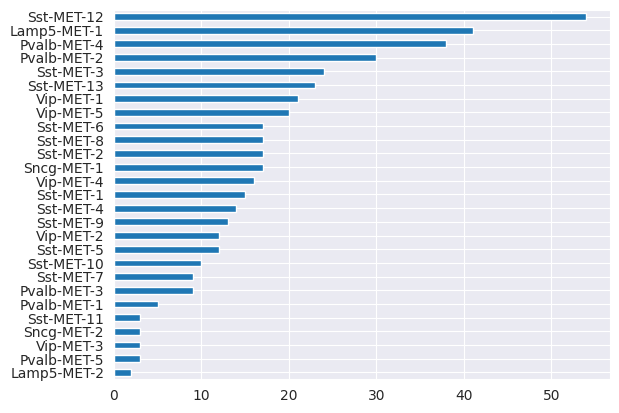

In [7]:
ct_df = pd.DataFrame({'ct':adatas_all[0].obs['cell_type_TEM'].values})
plt.figure()
ct_df.ct.value_counts().sort_values().plot(kind = 'barh')


In [8]:

model.load_model(f"{root_save_path}/train_best.pt",device=torch.device(device))
model.model.device_in_use = device
losses = model.evaluate(adatas_all,give_losses=True,stage='train')
predict_label = model.predict_label(adatas_all)
adata_fused = model.infer(adatas_all)
adata_fused.obs['label'] = list(adatas_all[0].obs['label'])
adata_fused.obs['label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['label'].values]


In [9]:
from sklearn.utils.multiclass import unique_labels


pseudo_label = np.array(adata_fused.obs['predicted_label'].values)
cmat = confusion_matrix(adata_fused.obs['label'], pseudo_label)
ri, ci = linear_sum_assignment(-cmat)
ordered_all = cmat[np.ix_(ri, ci)]
major_sub_names = {}
pred_labels_re_order = copy.deepcopy(pseudo_label)
for re_oder,(lb_correct,lb) in enumerate(zip(unique_labels(adata_fused.obs['label'], pseudo_label)[ri],
                                unique_labels(adata_fused.obs['label'], pseudo_label)[ci])):
  idx = pseudo_label==lb
  if any(idx):
    nm = '-'.join(lb_correct.split('-')[:-1])
    if nm in major_sub_names.keys():
      major_sub_names[nm]+=1
    else:
      major_sub_names[nm]=1
    
    pred_labels_re_order[idx] = f'{nm}-{major_sub_names[nm]}-Uni'

adata_fused.obs['predicted_label'] = pred_labels_re_order


FileNotFoundError: [Errno 2] No such file or directory: './figures/major_matching_heatmap.pdf'

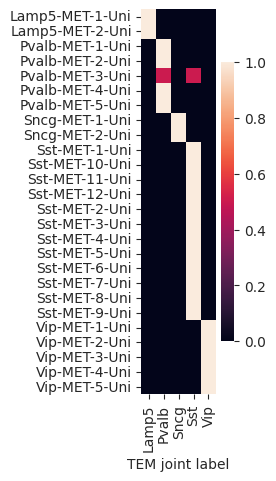

In [10]:
sns.set_style('ticks')
adata_fused.obs['predicted_label_less'] = [ct.split('-')[0] for ct in adata_fused.obs['predicted_label'].values]
cmat = confusion_matrix(adata_fused.obs['predicted_label'], adata_fused.obs['label_less'])
cmat = cmat[:,cmat.sum(axis=0)!=0]
cmat = cmat[cmat.sum(axis=1)!=0,:]
cmat = (cmat.T / cmat.sum(axis=1)).T

fig,ax = plt.subplots(figsize=[1.2,5])
sns.heatmap(cmat,ax=ax,yticklabels=unique_labels(adata_fused.obs['predicted_label']),xticklabels=unique_labels(adata_fused.obs['label_less']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/major_matching_heatmap.pdf')

fig,ax = plt.subplots(figsize=[6,5])
ordered = ordered_all[:,ordered_all.sum(axis=0)!=0]
ordered = ordered[ordered.sum(axis=1)!=0,:]
ordered_re = ordered.T
ordered_norm = (ordered_re.T / ordered_re.sum(axis=1)).T

sns.heatmap(ordered_norm,ax=ax,xticklabels=unique_labels(adata_fused.obs['label']),yticklabels=unique_labels(adata_fused.obs['predicted_label']),vmin=0, vmax=1)
plt.xlabel('TEM joint label')
plt.savefig('./figures/sub_matching_heatmap.pdf')





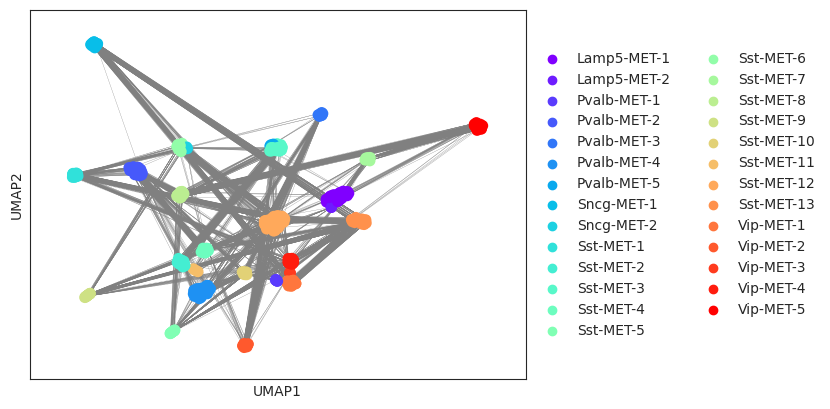

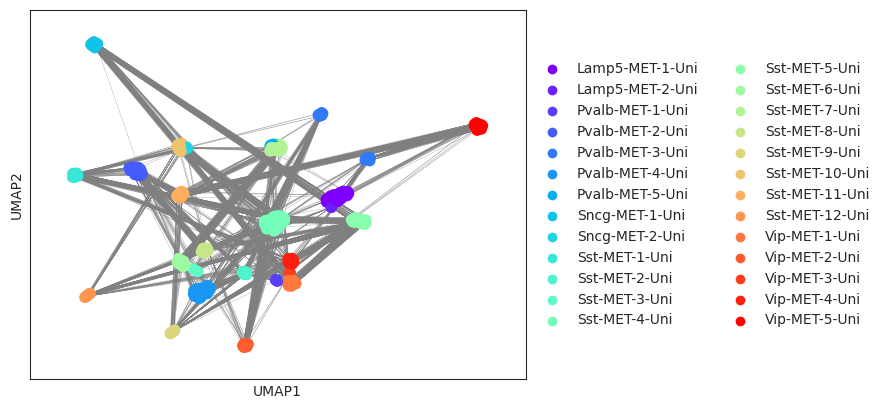

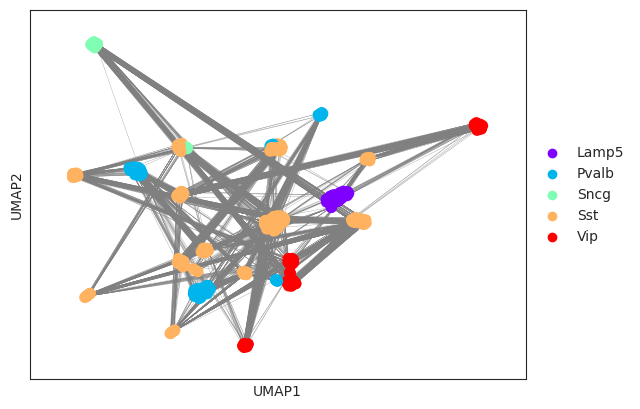

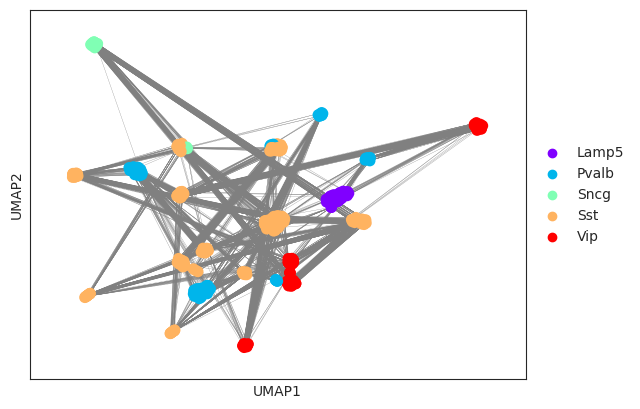

In [12]:

sc.pl.umap(adata_fused,color=['label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_orig_MET.pdf')
sc.pl.umap(adata_fused,color=['predicted_label'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_Uni_MET.pdf')


sc.pl.umap(adata_fused,color=['label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison.pdf')
sc.pl.umap(adata_fused,color=['predicted_label_less'],palette='rainbow',show=True,edges=True,edges_width = 0.2,linewidth=1000,edgecolors='k',title='',save='patch_seq_2D_MET_comparison_no_legend.pdf')
